In [1]:
import os
import yaml
from PIL import Image, ImageDraw
from tqdm import tqdm
import shutil

# Definimos funciones necesarias a utilizar

In [2]:
def contarLineas(archivoNombre):
    with open(archivoNombre,'r') as archivo:
        lineas = archivo.readlines()
        nLineas = len(lineas)

    return nLineas

def concatenarTestLabels(archivosConcat,archivoSalida):
    with open(archivo_salida, 'w') as salida:
        # Itera sobre la lista de archivos a concatenar
        for archivo in archivos_a_concatenar:
            # Abre cada archivo en modo lectura
            with open(archivo, 'r') as entrada:
                # Lee el contenido del archivo y escribe en el archivo de salida
                contenido = entrada.read()
                salida.write(contenido)

def pintar_imagenes_box(image_path):
    label_path = "Annotations_RGB_txt/" + image_path[:-4] + ".txt"
    image_path = "Images_RGB/" + image_path
    print(image_path)
    print(label_path)
    # Open the image and create ImageDraw object for drawing
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    colores = ["red","green","blue","yellow","pink"]
    with open(label_path, 'r') as f:
        for line in f.readlines():
            # Split the line into five values
            label, x, y, w, h = line.split(' ')
            
            # Convert string into float
            label = int(label)
            x = float(x)
            y = float(y)
            w = float(w)
            h = float(h)

            # Convert center position, width, height into
            # top-left and bottom-right coordinates
            W, H = image.size
            x1 = (x - w/2) * W
            y1 = (y - h/2) * H
            x2 = (x + w/2) * W
            y2 = (y + h/2) * H

            # Draw the bounding box with red lines
            draw.rectangle((x1, y1, x2, y2),
                           outline=colores[label], # Red in RGB
                           width=5)             # Line width
    image.show()
    image.close()

def convertir_yml_into_txt_YOLOV5(entrada,salida):
    entrada_yaml = entrada
    salida_txt = salida

    # Leer el archivo YAML
    with open(entrada_yaml, 'r') as file:
        data = yaml.safe_load(file)

    # Verificar si hay objetos en el archivo YAML
    if 'object' in data['annotation']:
        # Crear una lista para almacenar las etiquetas convertidas
        etiquetas_yolo = []

        # Iterar sobre cada objeto en el archivo YAML
        for obj in data['annotation']['object']:
            # Obtener el nombre de la etiqueta
            label = 0 if obj['name'] == "person" else 1 if obj['name'] == "wheelchair" else 2 if obj['name'] == "push_wheelchair" else 3 if obj['name'] == "crutches" else 4 if obj['name'] == "walking_frame" else -1
            # Obtener las coordenadas delimitadoras
            xmin = float(obj['bndbox']['xmin'])
            ymin = float(obj['bndbox']['ymin'])
            xmax = float(obj['bndbox']['xmax'])
            ymax = float(obj['bndbox']['ymax'])

            # Calcular las coordenadas relativas al ancho y alto de la imagen
            width = float(data['annotation']['size']['width'])
            height = float(data['annotation']['size']['height'])

            x_center = (xmin + xmax) / (2 * width)
            y_center = (ymin + ymax) / (2 * height)
            w = (xmax - xmin) / width
            h = (ymax - ymin) / height

            # Agregar la etiqueta convertida a la lista
            etiquetas_yolo.append(f"{label} {x_center} {y_center} {w} {h}")

        # Escribir las etiquetas convertidas al archivo de salida
        with open(salida_txt, 'w') as file:
            for label_yolo in etiquetas_yolo:
                file.write(label_yolo + '\n')

    else:
        # Si no hay objetos, crea un archivo de texto vacío
        open(salida_txt, 'w').close()

# Resumen para ver que concuerda el número de imágenes y archivos de etiquetas

In [3]:
nImagenes = len(os.listdir("Images_RGB"))
print("Número total de imágenes: ", nImagenes)
nLabels = len(os.listdir("Annotations_RGB")) + len(os.listdir("Annotations_RGB_TestSet2"))
print("Número total de archivos de etiquetas: ", nLabels)

# Lista de nombres de archivos que quieres concatenar
archivos_a_concatenar = ['ImageSets/TestSet1.txt', 'ImageSets/TestSet2_seq1.txt', 'ImageSets/TestSet2_seq2.txt','ImageSets/TestSet2_seq3.txt','ImageSets/TestSet2_seq4.txt']
archivo_salida = 'ImageSets/TestSet_RGB.txt'
concatenarTestLabels(archivos_a_concatenar,archivo_salida)
nTest = contarLineas("ImageSets/TestSet_RGB.txt")
nTrain = contarLineas("ImageSets/TrainSet_RGB.txt")


print("Número de imágenes de TRAIN: ", nTrain)
print("Número de imágenes de Test: ", nTest)

Número total de imágenes:  17079
Número total de archivos de etiquetas:  17079
Número de imágenes de TRAIN:  10961
Número de imágenes de Test:  6118


# Creando una carpeta con todos los archivos txt de los labels

In [4]:
labels=[]
for archivo in os.listdir("Annotations_RGB"):
    labels.append("Annotations_RGB/" + archivo)
for archivo in os.listdir("Annotations_RGB_TestSet2"):
    labels.append("Annotations_RGB_TestSet2/" + archivo)
print(len(labels))

17079


In [5]:
for archivo in tqdm(labels):
   entrada = archivo
   salida = "Annotations_RGB_txt/" + archivo[-29:-4] + ".txt"
   convertir_yml_into_txt_YOLOV5(entrada,salida)

print(len(os.listdir("Annotations_RGB_txt")))

100%|████████████████████████████████████████████████████████████████████████████| 17079/17079 [00:39<00:00, 430.50it/s]

17079


# Vemos el número de elementos por categoría

In [14]:
import os
from tqdm import tqdm
def categorizar_archivos(ruta):
    categorias = []
    NumeroPersonas=0
    NumeroPersonasEnSillas=0
    NumeroPersonasEmpujandoSilla=0
    NumeroPersonasMuletas=0
    NumeroPersonasAndador=0
    NumeroNegativo=0
    for root, dirs, files in os.walk(ruta+"/labels"):
        for file in tqdm(files):
            if file.endswith('.txt'):
                path_archivo = os.path.join(root, file)
                with open(path_archivo, 'r') as archivo:
                    lineas = archivo.readlines()
                    for line in lineas:
                        if line.startswith('0'):
                            NumeroPersonas += 1
                        elif line.startswith('1'):
                            NumeroPersonasEnSillas += 1
                        elif line.startswith('2'):
                          NumeroPersonasEmpujandoSilla += 1
                        elif line.startswith('3'):
                          NumeroPersonasMuletas += 1
                        elif line.startswith('4'):
                          NumeroPersonasAndador += 1
                        elif line.startswith('-1'):
                          NumeroNegativo += 1
                    # Categoría 1: Solo un objeto, persona sin problema movilidad
                    if len(lineas) == 1 and (lineas[0].startswith('0') or lineas[0].startswith('2')):
                        categorias.append(0)
                     #Categoría 2: Solo un objeto, persona con problema movilidad
                    elif len(lineas) == 1 and (lineas[0].startswith('1') or lineas[0].startswith('3') or lineas[0].startswith('4')):
                        categorias.append(1)
                    # Categoria 3: Combinacion objetos, todos personas sin problema movilidad
                    elif len(lineas) > 1 and all(line.startswith('0') or line.startswith('2') for line in lineas):
                        categorias.append(2)
                    # Categoria 4: Combinacion objetos, todos personas con problema movilidad
                    elif len(lineas) > 1 and all(line.startswith('1') or line.startswith('3') or line.startswith('4') for line in lineas):
                        categorias.append(3)
                    #Categoria 5: Combinación objetos, personas con y sin problemas de movilidad
                    else:
                        categorias.append(4)
    print(f'Hay {NumeroPersonas} de personas, {NumeroPersonasEnSillas} en sillas de ruedas, {NumeroPersonasEmpujandoSilla} empujando sillas, {NumeroPersonasMuletas} con muletas y {NumeroPersonasAndador} con andador')
    return categorias

ruta_carpeta_labels = '/home/vtoscano/Investigacion/repoNuevo/Dataset2/Annotations_RGB_txt'

categoriasNumeros = categorizar_archivos(ruta_carpeta_labels)

import pandas as pd
pd.value_counts(categoriasNumeros)

Hay 0 de personas, 0 en sillas de ruedas, 0 empujando sillas, 0 con muletas y 0 con andador


Series([], dtype: int64)

# Dibujando la imagén y su caja!

Images_RGB/seq_1477471591.0628319610.png
Annotations_RGB_txt/seq_1477471591.0628319610.txt


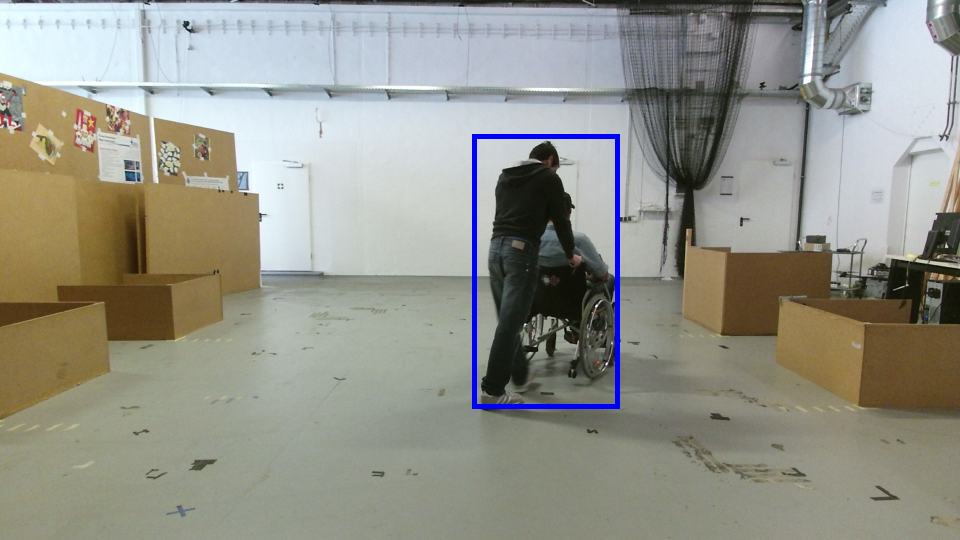

In [15]:
imagenes = os.listdir("Images_RGB")
i=0
pintar_imagenes_box(imagenes[i])

# Hacemos un split en Train/Test en una carpeta llamada dataYOLOv5

In [16]:
os.makedirs("dataYOLOv5/train/images")
os.makedirs("dataYOLOv5/train/labels")
os.makedirs("dataYOLOv5/test/images")
os.makedirs("dataYOLOv5/test/labels")


1) Cogemos todos los nombres de los archivos que van a ir a la carpeta test

In [17]:
archivosTest=[]
with open("ImageSets/TestSet_RGB.txt", 'r') as archivo:
    lineas = [linea.strip() for linea in archivo]
    for archivoNombre in lineas:
        archivosTest.append(archivoNombre)


2. Copiamos las etiquetas en sus correspondientes carpetas

In [18]:
x=[]
for archivo in tqdm(os.listdir("Annotations_RGB_txt")):
    path = "Annotations_RGB_txt/" + archivo
    if any(x in path for x in archivosTest):
        #van para test
        path_a_copiar = "dataYOLOv5/test/labels/" + archivo
        shutil.copy(path,path_a_copiar)
        os.remove(path)
        x.append("Test")
    else:
        path_a_copiar = "dataYOLOv5/train/labels/" + archivo
        shutil.copy(path,path_a_copiar)
        os.remove(path)
        x.append("Train")

100%|███████████████████████████████████████████████████████████████████████████| 17079/17079 [00:10<00:00, 1647.01it/s]


3. Copiamos las imagenes en sus correspondientes carpetas

In [19]:
y=[]
for archivo in tqdm(os.listdir("Images_RGB")):
    path = "Images_RGB/" + archivo
    if any(x in path for x in archivosTest):
        #van para test
        path_a_copiar = "dataYOLOv5/test/images/" + archivo
        shutil.copy(path,path_a_copiar)
        os.remove(path)
        y.append("Test")
    else:
        path_a_copiar = "dataYOLOv5/train/images/" + archivo
        shutil.copy(path,path_a_copiar)
        os.remove(path)
        y.append("Train")

100%|████████████████████████████████████████████████████████████████████████████| 17079/17079 [00:18<00:00, 937.76it/s]


In [20]:
print(len(os.listdir("dataYOLOv5/train/images/")))
print(len(os.listdir("dataYOLOv5/train/labels/")))
print(len(os.listdir("dataYOLOv5/test/images/")))
print(len(os.listdir("dataYOLOv5/test/labels/")))

10961
10961
6118
6118


# Creamos el archivo .yaml especifico de este dataset.

In [21]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [22]:
%%writetemplate data.yaml
names:
- pedestrian
- wheelchair
- push_wheelchair
- crutches
- walking-frame
nc: 5
test: ../Dataset2/dataYOLOv5/test/images
train: ../Dataset2/dataYOLOv5/train/images
val: ../Dataset2/dataYOLOv5/test/images

LISTO!